In [1]:
import os, psutil
import gc

import numpy as np
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB 

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate,cross_val_score,train_test_split, KFold, GridSearchCV, LearningCurveDisplay, ValidationCurveDisplay
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn import ensemble,metrics,model_selection,neighbors,preprocessing, svm, tree
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

import lightgbm as lgb
from lightgbm import LGBMClassifier

from statsmodels.graphics.mosaicplot import mosaic

from time import time
import warnings

In [2]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )
print('Function built')

Function built
CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

## from: https://www.kaggle.com/bextuychiev/how-to-work-w-million-row-datasets-like-a-pro
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

CPU times: total: 0 ns
Wall time: 0 ns


In [4]:
# Modified from HW 5 Q2 Part a.
def train_and_evaluate_classifier(name, clf, X_train, y_train, X_test, y_test, debug=False, learning_curve=False, confusion=False):
  print(name)
    
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)
  ### END CODE ###
  print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)
  print("predict time", round(time()-t0, 3), "s")

  print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  #print(confusion_matrix(y_test, y_pred))
  # ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train)
  if confusion == True:
      ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
      plt.show()
  ### END CODE ###


  ### START CODE ###
  y_train_pred_proba = clf.predict_proba(X_train)
  y_test_pred_proba = clf.predict_proba(X_test)
    
  if debug == True:
      print(y_test_pred_proba)
      
  train_acc_score = accuracy_score(y_train, y_train_pred)
  test_acc_score = accuracy_score(y_test, y_test_pred)

  train_auc_score_ovo = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovo')  
  train_auc_score_ovr = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    
  test_auc_score_ovo = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo')  
  test_auc_score_ovr = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovr')
  ### END CODE ###

  print("TRAIN - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(train_acc_score, train_auc_score_ovo, train_auc_score_ovr))
  print("TEST - Accuracy: {}, AUC_ROC_OVO: {}, AUC_ROC_OVR: {}".format(test_acc_score, test_auc_score_ovo, test_auc_score_ovr))

  # Display Learning curve
  if learning_curve == True:
      LearningCurveDisplay.from_estimator(clf, X_train, y_train, scoring='accuracy')
  #RocCurveDisplay.from_estimator(clf, X_test, y_test)

  train_results = [train_acc_score, train_auc_score_ovo, train_auc_score_ovr]
  test_results = [test_acc_score, test_auc_score_ovo, test_auc_score_ovr]
  return train_results, test_results

In [5]:
df = pd.read_csv('dataset/train.csv')
# df = df.drop(columns='id')

count    20758.000000
mean        30.241842
std          8.333932
min         12.868541
25%         24.088223
50%         29.384757
75%         37.011168
max         54.997991
Name: BMI, dtype: float64

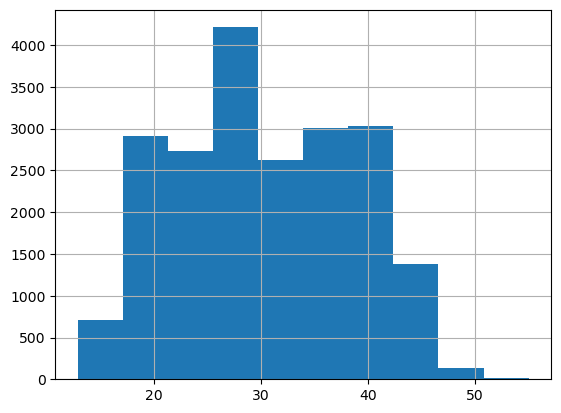

In [6]:
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'].hist()
df['BMI'].describe()

In [7]:
df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II,28.899693


In [8]:
df_lean = reduce_memory_usage(df, verbose=True)
# test = reduce_memory_usage(test, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 1.82 Mb (39.5% reduction)
memory GB:0.2
Memory reduced


features obtained


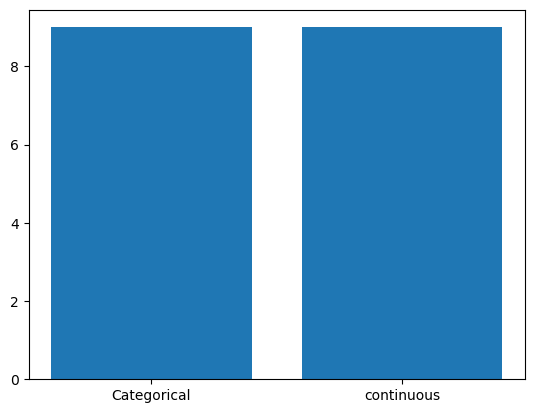

CPU times: total: 78.1 ms
Wall time: 76.4 ms


In [9]:
%%time
features=[]
cat_features=[]
cont_features=[]
for feature in df_lean.columns:
    features.append(feature)
    if df_lean.dtypes[feature] in ['int8', 'object']:
        cat_features.append(feature)
    if df_lean.dtypes[feature]=='float16':
        cont_features.append(feature)
    #print(test.dtypes[feature])
print('features obtained')

plt.bar([1,2],[len(cat_features),len(cont_features)])
plt.xticks([1,2],('Categorical','continuous'))
plt.show()

In [10]:
%%time
# Get shape of data
print('*'*40, '\nHow much data was imported?')
print('*'*40)
print('Training data :', df_lean.shape)
# print('Test data :', test.shape)
print('*'*40,"\n")

# missing data
print('*'*40,'\nHow much data is missing?')
print('*'*40)
training_missing_val_count_by_column = (df_lean.isnull().values.sum())
# test_missing_val_count_by_column = (test.isnull().values.sum())
print('Missing training data :  {:.2f} ({:.1f})%'.format (training_missing_val_count_by_column,training_missing_val_count_by_column/df_lean.shape[0]))
# print('Missing test data :  {:.2f} ({:.1f})%'.format (test_missing_val_count_by_column,test_missing_val_count_by_column/test.shape[0]))
print('*'*40,"\n")

# categorical data
print('*'*40,'\nFeature types?')
print('*'*40)
print('Categorical features : ', (len(cat_features)))
print('Continuous features : ', (len(cont_features)))
print('*'*40,'\n')

# get info
print('*'*40,'\nInfo on datasets')
print('*'*40)
print(df_lean.info(),'\n')
# print(test.info(),'\n')
print('*'*40)

print('\noverview complete')
del training_missing_val_count_by_column #,test_missing_val_count_by_column

**************************************** 
How much data was imported?
****************************************
Training data : (20758, 19)
**************************************** 

**************************************** 
How much data is missing?
****************************************
Missing training data :  0.00 (0.0)%
**************************************** 

**************************************** 
Feature types?
****************************************
Categorical features :  9
Continuous features :  9
**************************************** 

**************************************** 
Info on datasets
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int16  
 1   Gender                          20758 no

In [11]:
y = df['NObeyesdad']
X = df.drop(columns='NObeyesdad')

y_lean = df_lean['NObeyesdad']
X_lean = df_lean.drop(columns='NObeyesdad')

In [12]:
X

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
0,0,Male,24.437500,1.700195,81.68750,yes,yes,2.000000,2.982422,Sometimes,no,2.763672,no,0.000000,0.976562,Sometimes,Public_Transportation,28.265625
1,1,Female,18.000000,1.559570,57.00000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,23.421875
2,2,Female,18.000000,1.711914,50.15625,yes,yes,1.880859,1.412109,Sometimes,no,1.910156,no,0.866211,1.673828,no,Public_Transportation,17.125000
3,3,Female,20.953125,1.710938,131.25000,yes,yes,3.000000,3.000000,Sometimes,no,1.673828,no,1.467773,0.780273,Sometimes,Public_Transportation,44.843750
4,4,Male,31.640625,1.914062,93.81250,yes,yes,2.679688,1.971680,Sometimes,no,1.979492,no,1.967773,0.931641,Sometimes,Public_Transportation,25.593750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.140625,1.766602,114.18750,yes,yes,2.919922,3.000000,Sometimes,no,2.152344,no,1.330078,0.196655,Sometimes,Public_Transportation,36.593750
20754,20754,Male,18.000000,1.709961,50.00000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,17.093750
20755,20755,Male,20.093750,1.819336,105.56250,yes,yes,2.408203,3.000000,Sometimes,no,2.000000,no,1.158203,1.198242,no,Public_Transportation,31.890625
20756,20756,Male,33.843750,1.700195,83.50000,yes,yes,2.671875,1.971680,Sometimes,no,2.144531,no,0.000000,0.973633,no,Automobile,28.906250


In [13]:
y

0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [14]:
ordinalCT = OrdinalEncoder()

ordinalCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OrdinalEncoder(), cat_features[:-1]),
        ]
    )

ordinalCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features[:-1]),
        ]
    )

ordinalCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OrdinalEncoder(), cat_features[:-1]),
        ]
    )

# Removed due to memory issues
# oneHotCT = OneHotEncoder() 


oneHotCatOnlyCT = ColumnTransformer(
        [
            ("numerical", "passthrough", cont_features),
            ("categorical", OneHotEncoder(drop='if_binary'), cat_features[:-1]),
        ]
    )

oneHotCatStandardCT = ColumnTransformer(
        [
            ("numerical", StandardScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary'), cat_features[:-1]),
        ]
    )

oneHotCatRobustCT = ColumnTransformer(
        [
            ("numerical", RobustScaler(), cont_features),
            ("categorical", OneHotEncoder(drop='if_binary'), cat_features[:-1]),
        ]
    )

CTs = [ordinalCT, ordinalCatOnlyCT, ordinalCatStandardCT, ordinalCatRobustCT, 
       # oneHotCT, 
       oneHotCatOnlyCT, oneHotCatStandardCT, oneHotCatRobustCT]
preprocessed = ["(Ordinal)", "(Ordinal Categorical Only - No Scaling)", "(Ordinal Categorical Only - Standard Scaler)", "(Ordinal Categorical Only - Robust Scaler)",
                # "(One Hot)", 
                "(One Hot Categorical Only - No Scaling)", "(One Hot Categorical Only - Standard Scaler)", "(One Hot Categorical Only - Robust Scaler)"]

if len(CTs) != len(preprocessed):
    print("NUMBER OF TRANSFORMERS != NUMBER OF PREPROCESSED DATASETS") 

In [15]:
# TEST WITH DIFFERENT ENCODERS: ORDINAL, ONE-HOT, TARGET
lean = True
if lean == True:
    X = X_lean
    y = y_lean

X_s = []
for CT in CTs:
    X_s.append(CT.fit_transform(X, y))

X_train = [None] * len(X_s)
X_test = [None] * len(X_s)
y_train = [None] * len(X_s)
y_test = [None] * len(X_s)

for i, X in enumerate(X_s):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X, y, test_size=1/3, random_state=42)


In [16]:
# pipes[1]['columntransformer'].get_params()['categorical'].categories_

In [17]:
# Model 1 - Decision Tree
test = []
models = []
for i, name in enumerate(preprocessed):
    model = DecisionTreeClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"Decision Tree {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    models.append(model)
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

Decision Tree (Ordinal)
training time 0.198 s
predict time 0.005 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.8317919075144509, AUC_ROC_OVO: 0.8917904702890153, AUC_ROC_OVR: 0.8934122472435801

Decision Tree (Ordinal Categorical Only - No Scaling)
training time 0.144 s
predict time 0.003 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.844364161849711, AUC_ROC_OVO: 0.8998130576606488, AUC_ROC_OVR: 0.9013261911503497

Decision Tree (Ordinal Categorical Only - Standard Scaler)
training time 0.145 s
predict time 0.004 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.8424855491329479, AUC_ROC_OVO: 0.8986313252297018, AUC_ROC_OVR: 0.900155653772417

Decision Tree (Ordinal Categorical Only - Robust Scaler)
training time 0.141 s
predict time 0.004 s
Confusion matrix: 
TRAIN - Accuracy: 1.0, AUC_ROC_OVO: 1.0, AUC_ROC_OVR: 1.0
TEST - Accuracy: 0.

In [18]:
# Model 2a - Logistic Regression
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LogisticRegression(max_iter = 5000)
    train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

Logistic Regression (Ordinal)


D:\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training time 12.564 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8277207688972394, AUC_ROC_OVO: 0.9674715324249583, AUC_ROC_OVR: 0.9709120584648728
TEST - Accuracy: 0.833092485549133, AUC_ROC_OVO: 0.9680541009324641, AUC_ROC_OVR: 0.9714448287790461

Logistic Regression (Ordinal Categorical Only - No Scaling)


D:\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training time 11.813 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8579274461627403, AUC_ROC_OVO: 0.9761278348896512, AUC_ROC_OVR: 0.9786511851175849
TEST - Accuracy: 0.8573699421965318, AUC_ROC_OVO: 0.9757063588666238, AUC_ROC_OVR: 0.9782369908385417

Logistic Regression (Ordinal Categorical Only - Standard Scaler)
training time 1.757 s
predict time 0.001 s
Confusion matrix: 
TRAIN - Accuracy: 0.8648648648648649, AUC_ROC_OVO: 0.9772954653296385, AUC_ROC_OVR: 0.9796690781272906
TEST - Accuracy: 0.8615606936416185, AUC_ROC_OVO: 0.9768718834704421, AUC_ROC_OVR: 0.9792396274470896

Logistic Regression (Ordinal Categorical Only - Robust Scaler)
training time 1.487 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8611793611793612, AUC_ROC_OVO: 0.9765440564053522, AUC_ROC_OVR: 0.9790058751550667
TEST - Accuracy: 0.8586705202312138, AUC_ROC_OVO: 0.9762995126314957, AUC_ROC_OVR: 0.978739460246952

Logistic Regression (One Hot Categorical Only - No Scaling)


D:\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training time 12.166 s
predict time 0.001 s
Confusion matrix: 
TRAIN - Accuracy: 0.8633473045237751, AUC_ROC_OVO: 0.9777297077342527, AUC_ROC_OVR: 0.9799970453977639
TEST - Accuracy: 0.8593930635838151, AUC_ROC_OVO: 0.9768604224618529, AUC_ROC_OVR: 0.9791713500131403

Logistic Regression (One Hot Categorical Only - Standard Scaler)
training time 0.92 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8690562219973985, AUC_ROC_OVO: 0.9786102415351492, AUC_ROC_OVR: 0.9807906172173395
TEST - Accuracy: 0.8647398843930636, AUC_ROC_OVO: 0.9779787509193283, AUC_ROC_OVR: 0.9801841765661531

Logistic Regression (One Hot Categorical Only - Robust Scaler)
training time 1.009 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8654429830900419, AUC_ROC_OVO: 0.977875026456353, AUC_ROC_OVR: 0.9801414180903506
TEST - Accuracy: 0.8609826589595375, AUC_ROC_OVO: 0.9774222753539712, AUC_ROC_OVR: 0.9796933017359323

Best Preprocessing: (One Hot Categorical Only - Standard Scaler) - Te

In [19]:
# Model 2b - Logistic Regression w/ CV
# warnings.filterwarnings('ignore')

# test = []
# models = []
# for i, name in enumerate(preprocessed):
#     model = LogisticRegressionCV(max_iter = 1000)
#     train_results, test_results = train_and_evaluate_classifier(f"Logistic Regression CV {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
#     test.append(test_results[0])
#     print()
    
# test = np.array(test)
# loc_best_test = np.argmax(test)
# print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
# best_model = models[loc_best_test]

In [20]:
# Model 3 - MLP
test = []
models = []
for i, name in enumerate(preprocessed):
    model = MLPClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"MLP {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

MLP (Ordinal)
training time 1.069 s
predict time 0.01 s
Confusion matrix: 
TRAIN - Accuracy: 0.6861540685070097, AUC_ROC_OVO: 0.9358598416399189, AUC_ROC_OVR: 0.9414623182466616
TEST - Accuracy: 0.6684971098265896, AUC_ROC_OVO: 0.9321641365134322, AUC_ROC_OVR: 0.9381407749233056

MLP (Ordinal Categorical Only - No Scaling)
training time 7.771 s
predict time 0.019 s
Confusion matrix: 
TRAIN - Accuracy: 0.8689839572192514, AUC_ROC_OVO: 0.9811090604296803, AUC_ROC_OVR: 0.9830641276794767
TEST - Accuracy: 0.8605491329479769, AUC_ROC_OVO: 0.9794234117520177, AUC_ROC_OVR: 0.9815346387870868

MLP (Ordinal Categorical Only - Standard Scaler)


D:\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


training time 8.848 s
predict time 0.009 s
Confusion matrix: 
TRAIN - Accuracy: 0.9061280531868767, AUC_ROC_OVO: 0.9886267300012761, AUC_ROC_OVR: 0.9898551516338162
TEST - Accuracy: 0.8767341040462427, AUC_ROC_OVO: 0.9826110067345075, AUC_ROC_OVR: 0.9844513499686359

MLP (Ordinal Categorical Only - Robust Scaler)


D:\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


training time 7.663 s
predict time 0.011 s
Confusion matrix: 
TRAIN - Accuracy: 0.9035987859517272, AUC_ROC_OVO: 0.9881213125013539, AUC_ROC_OVR: 0.9893814991777088
TEST - Accuracy: 0.8758670520231214, AUC_ROC_OVO: 0.9820281603439983, AUC_ROC_OVR: 0.9839188932448373

MLP (One Hot Categorical Only - No Scaling)


D:\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


training time 7.436 s
predict time 0.022 s
Confusion matrix: 
TRAIN - Accuracy: 0.8778725249313485, AUC_ROC_OVO: 0.9826697623114733, AUC_ROC_OVR: 0.9843917715990184
TEST - Accuracy: 0.8664739884393063, AUC_ROC_OVO: 0.9797203013756433, AUC_ROC_OVR: 0.9817143274510549

MLP (One Hot Categorical Only - Standard Scaler)


D:\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


training time 7.764 s
predict time 0.009 s
Confusion matrix: 
TRAIN - Accuracy: 0.911258852435323, AUC_ROC_OVO: 0.990088632984679, AUC_ROC_OVR: 0.9911755514381831
TEST - Accuracy: 0.8761560693641619, AUC_ROC_OVO: 0.9811773444485065, AUC_ROC_OVR: 0.9831619792060244

MLP (One Hot Categorical Only - Robust Scaler)
training time 7.696 s
predict time 0.01 s
Confusion matrix: 
TRAIN - Accuracy: 0.9097412920942333, AUC_ROC_OVO: 0.989452524080987, AUC_ROC_OVR: 0.9906108570298573
TEST - Accuracy: 0.8719653179190752, AUC_ROC_OVO: 0.9813488894582512, AUC_ROC_OVR: 0.9833223829616065

Best Preprocessing: (Ordinal Categorical Only - Standard Scaler) - Test Accuracy: 0.8767341040462427


D:\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
# Model 4 - KNN
test = []
models = []
for i, name in enumerate(preprocessed):
    model = KNeighborsClassifier()
    train_results, test_results = train_and_evaluate_classifier(f"KNN {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

KNN (Ordinal)
training time 0.01 s
predict time 0.5 s
Confusion matrix: 
TRAIN - Accuracy: 0.8171701112877583, AUC_ROC_OVO: 0.975022758923949, AUC_ROC_OVR: 0.9776351384980465
TEST - Accuracy: 0.7102601156069365, AUC_ROC_OVO: 0.9094310674889208, AUC_ROC_OVR: 0.9149178438896463

KNN (Ordinal Categorical Only - No Scaling)
training time 0.01 s
predict time 0.302 s
Confusion matrix: 
TRAIN - Accuracy: 0.9055499349616997, AUC_ROC_OVO: 0.9931785085684597, AUC_ROC_OVR: 0.9939239016292246
TEST - Accuracy: 0.8715317919075144, AUC_ROC_OVO: 0.9607794937008943, AUC_ROC_OVR: 0.9621066621106241

KNN (Ordinal Categorical Only - Standard Scaler)
training time 0.01 s
predict time 0.274 s
Confusion matrix: 
TRAIN - Accuracy: 0.863275039745628, AUC_ROC_OVO: 0.9837867483648243, AUC_ROC_OVR: 0.9855088057983992
TEST - Accuracy: 0.7923410404624277, AUC_ROC_OVO: 0.9367079473552169, AUC_ROC_OVR: 0.9401556394682807

KNN (Ordinal Categorical Only - Robust Scaler)
training time 0.01 s
predict time 0.271 s
Confusi

In [22]:
# Model 5 - SVM
test = []
models = []
for i, name in enumerate(preprocessed):
    model = SVC(probability=True)
    train_results, test_results = train_and_evaluate_classifier(f"SVM {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

SVM (Ordinal)
training time 49.653 s
predict time 25.636 s
Confusion matrix: 
TRAIN - Accuracy: 0.7800982800982801, AUC_ROC_OVO: 0.9627000152061443, AUC_ROC_OVR: 0.9664173338477363
TEST - Accuracy: 0.7841040462427745, AUC_ROC_OVO: 0.9634860383761233, AUC_ROC_OVR: 0.9671424096706788

SVM (Ordinal Categorical Only - No Scaling)
training time 18.227 s
predict time 18.462 s
Confusion matrix: 
TRAIN - Accuracy: 0.8223731753143518, AUC_ROC_OVO: 0.9680527033475511, AUC_ROC_OVR: 0.9711461386643473
TEST - Accuracy: 0.825, AUC_ROC_OVO: 0.9680601643698608, AUC_ROC_OVR: 0.971128695996419

SVM (Ordinal Categorical Only - Standard Scaler)
training time 12.435 s
predict time 11.806 s
Confusion matrix: 
TRAIN - Accuracy: 0.8947824830177772, AUC_ROC_OVO: 0.9854593748431888, AUC_ROC_OVR: 0.9870524232556142
TEST - Accuracy: 0.8758670520231214, AUC_ROC_OVO: 0.9818588467979606, AUC_ROC_OVR: 0.9838479333918295

SVM (Ordinal Categorical Only - Robust Scaler)
training time 13.596 s
predict time 12.478 s
Confu

In [23]:
# Model 6a - LDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = LinearDiscriminantAnalysis()
    if sci.sparse.issparse(X_train[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i].toarray(), y_train[i], X_test[i], y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"LDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

LDA (Ordinal)
training time 0.049 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8507009683480272, AUC_ROC_OVO: 0.9749905057330462, AUC_ROC_OVR: 0.9776002396123047
TEST - Accuracy: 0.8536127167630058, AUC_ROC_OVO: 0.9756628965073094, AUC_ROC_OVR: 0.9782221269940374

LDA (Ordinal Categorical Only - No Scaling)
training time 0.044 s
predict time 0.001 s
Confusion matrix: 
TRAIN - Accuracy: 0.8254082959965313, AUC_ROC_OVO: 0.970822110088168, AUC_ROC_OVR: 0.9738730511632675
TEST - Accuracy: 0.826878612716763, AUC_ROC_OVO: 0.9710007447796739, AUC_ROC_OVR: 0.9740311170650557

LDA (Ordinal Categorical Only - Standard Scaler)
training time 0.046 s
predict time 0.002 s
Confusion matrix: 
TRAIN - Accuracy: 0.8253360312183842, AUC_ROC_OVO: 0.9708246759382574, AUC_ROC_OVR: 0.973875246923294
TEST - Accuracy: 0.8270231213872833, AUC_ROC_OVO: 0.9710039694683866, AUC_ROC_OVR: 0.9740339011825909

LDA (Ordinal Categorical Only - Robust Scaler)
training time 0.043 s
predict time 0.002 s
Co

In [24]:
# Model 6b - QDA
test = []
models = []
for i, name in enumerate(preprocessed):
    model = QuadraticDiscriminantAnalysis(reg_param=0.125)
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"QDA {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"QDA {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

QDA (Ordinal)
training time 0.018 s
predict time 0.023 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.8621188032952739, AUC_ROC_OVO: 0.9762354472351423, AUC_ROC_OVR: 0.9788592381859169
TEST - Accuracy: 0.8576589595375722, AUC_ROC_OVO: 0.9753550395511545, AUC_ROC_OVR: 0.978108665087693

QDA (Ordinal Categorical Only - No Scaling)
training time 0.015 s
predict time 0.018 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.8624078624078624, AUC_ROC_OVO: 0.9773228544272557, AUC_ROC_OVR: 0.9797739556105673
TEST - Accuracy: 0.8536127167630058, AUC_ROC_OVO: 0.9758046975679016, AUC_ROC_OVR: 0.978476077601559

QDA (Ordinal Categorical Only - Standard Scaler)
training time 0.016 s
predict time 0.018 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.8233126174302645, AUC_ROC_OVO: 0.9697432057352335, AUC_ROC_OVR: 0.9730799582715759
TEST - Accuracy: 0.8137283236994219, AUC_ROC_OVO: 0.9673634452773502, AUC_ROC_OVR: 0.97104402273638

QDA (Ordinal Categorical Only - Robust Scaler)
training time 0.015 s
predict time 0.019 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.7765573059690707, AUC_ROC_OVO: 0.9580535180199713, AUC_ROC_OVR: 0.9625225257248371
TEST - Accuracy: 0.7673410404624278, AUC_ROC_OVO: 0.9555902442325005, AUC_ROC_OVR: 0.9604740390469535

QDA (One Hot Categorical Only - No Scaling)
training time 0.046 s
predict time 0.032 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.8595895360601243, AUC_ROC_OVO: 0.9778151648740488, AUC_ROC_OVR: 0.980214151768074
TEST - Accuracy: 0.8534682080924856, AUC_ROC_OVO: 0.9761163565424331, AUC_ROC_OVR: 0.9787437851026571

QDA (One Hot Categorical Only - Standard Scaler)
training time 0.019 s
predict time 0.032 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.8124729007081948, AUC_ROC_OVO: 0.9693028015215118, AUC_ROC_OVR: 0.9726896259187524
TEST - Accuracy: 0.803757225433526, AUC_ROC_OVO: 0.9670295372277867, AUC_ROC_OVR: 0.9707438299077484

QDA (One Hot Categorical Only - Robust Scaler)
training time 0.018 s
predict time 0.031 s
Confusion matrix: 


D:\miniconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


TRAIN - Accuracy: 0.7562509033097269, AUC_ROC_OVO: 0.9573042255437927, AUC_ROC_OVR: 0.9618075689275528
TEST - Accuracy: 0.751878612716763, AUC_ROC_OVO: 0.9548172433556359, AUC_ROC_OVR: 0.9597463827947984

Best Preprocessing: (Ordinal) - Test Accuracy: 0.8576589595375722


In [37]:
# Model 7a - Gaussian Naive Bayes
test = []
models = []
indexes = [0, 1, 2, 3, 4, 5, 6]
for i in indexes:
    name = preprocessed[i]
    model = GaussianNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"Gaussian Naive Bayes {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"Gaussian Naive Bayes {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[loc_best_test]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

Gaussian Naive Bayes (Ordinal)
training time 0.018 s
predict time 0.025 s
Confusion matrix: 
TRAIN - Accuracy: 0.8233126174302645, AUC_ROC_OVO: 0.970121880014093, AUC_ROC_OVR: 0.9732423213317193
TEST - Accuracy: 0.8186416184971098, AUC_ROC_OVO: 0.9699738431386509, AUC_ROC_OVR: 0.9731241666015658

Gaussian Naive Bayes (Ordinal Categorical Only - No Scaling)
training time 0.016 s
predict time 0.018 s
Confusion matrix: 
TRAIN - Accuracy: 0.7821216938863997, AUC_ROC_OVO: 0.9547881447915763, AUC_ROC_OVR: 0.9595035079058872
TEST - Accuracy: 0.776878612716763, AUC_ROC_OVO: 0.9535419056065887, AUC_ROC_OVR: 0.9584276063481637

Gaussian Naive Bayes (Ordinal Categorical Only - Standard Scaler)
training time 0.017 s
predict time 0.019 s
Confusion matrix: 
TRAIN - Accuracy: 0.7816158404393698, AUC_ROC_OVO: 0.9528587149597659, AUC_ROC_OVR: 0.9576867447055883
TEST - Accuracy: 0.7760115606936416, AUC_ROC_OVO: 0.9519768822627706, AUC_ROC_OVR: 0.9569205277549292

Gaussian Naive Bayes (Ordinal Categorica

In [36]:
# Model 7e - Categorical Naive Bayes
test = []
indexes = [0, 1, 4]
for i in indexes:
    name = preprocessed[i]
    model = CategoricalNB()
    if sci.sparse.issparse(X_train[i]) or sci.sparse.issparse(X_test[i]) == True:
        train_results, test_results = train_and_evaluate_classifier(f"Categorical Naive Bayes {name}", model, X_train[i].toarray(), y_train[i], X_test[i].toarray(), y_test[i], confusion=False)
    else:
        train_results, test_results = train_and_evaluate_classifier(f"Categorical Naive Bayes {name}", model, X_train[i], y_train[i], X_test[i], y_test[i], confusion=False)
    test.append(test_results[0])
    print()
    
test = np.array(test)
print(f"Best Preprocessing: {preprocessed[indexes[np.argmax(test)]]} - Test Accuracy: {test[np.argmax(test)]}")

test = np.array(test)
loc_best_test = np.argmax(test)
print(f"Best Preprocessing: {preprocessed[indexes[loc_best_test]]} - Test Accuracy: {test[loc_best_test]}")
best_model = models[loc_best_test]

Categorical Naive Bayes (Ordinal)
training time 0.058 s
predict time 0.01 s
Confusion matrix: 
TRAIN - Accuracy: 0.9129932071108542, AUC_ROC_OVO: 0.993213125022609, AUC_ROC_OVR: 0.9939210261673922
TEST - Accuracy: 0.8408959537572255, AUC_ROC_OVO: 0.9762157869848122, AUC_ROC_OVR: 0.97874150775347

Categorical Naive Bayes (Ordinal Categorical Only - No Scaling)
training time 0.042 s
predict time 0.008 s
Confusion matrix: 
TRAIN - Accuracy: 0.8821361468420292, AUC_ROC_OVO: 0.9834472738516566, AUC_ROC_OVR: 0.9851615935444845
TEST - Accuracy: 0.8715317919075144, AUC_ROC_OVO: 0.9817656613940448, AUC_ROC_OVR: 0.9836640108223713

Categorical Naive Bayes (One Hot Categorical Only - No Scaling)
training time 0.05 s
predict time 0.012 s
Confusion matrix: 
TRAIN - Accuracy: 0.8784506431565255, AUC_ROC_OVO: 0.9825907948047528, AUC_ROC_OVR: 0.9843657100287333
TEST - Accuracy: 0.8689306358381503, AUC_ROC_OVO: 0.9808271717042771, AUC_ROC_OVR: 0.9827982360583041

Best Preprocessing: (Ordinal Categorica